# Continual Learning 데이터 만들기

## 데이터셋 다운로드

우선 데이터셋 다운로드부터 먼저 시작한다. 데이터셋은 미리 업로드된 구글 드라이브 링크로부터 다운로드하게 된다. 업로드된 파일을 내려받기 전에 프로젝트 디렉터리에 `data` 폴더가 있는지 검사하고 그 폴더 안에 각 데이터의 `.zip` 파일이 미리 받아졌는지 먼저 확인하고 (md5 해싱 이용) 파일이 문제가 없으면 압축을 푼다.

In [17]:
import os
import gdown
import hashlib
import zipfile

def get_hash(filename):
    with open(filename, "rb") as f:
        data = f.read()
        hash = hashlib.md5(data).hexdigest()
    
    return hash

data_info = {
    "cwru": {"link": "https://drive.google.com/uc?id=1JfnCzisg0wTSkWw_I5sNLcvQMD5mloJy",
             "hash": "a66d9ea53e5b9959829c1d1057abc377"},
    "mfpt": {"link": "https://drive.google.com/uc?id=1HDmX9-v8dV1-53nvM9lSDj-2-S2_Dss5",
             "hash": "fcf44622538307e33503cb7f24fd33d3"},
    "ottawa": {"link": "https://drive.google.com/uc?id=1WelJO5RMFwKoNdumhtW-__PC881fh4J_",
               "hash": "ca0142f52e950b5579985586a6acc96a"
    }
}

os.chdir(os.path.join(globals()['_dh'][0], ".."))

if not os.path.isdir("./data"):
    os.mkdir("./data")

for key in data_info:
    filename = f"./data/{key}.zip"
    if not os.path.isfile(filename):
        gdown.download(data_info[key]["link"], f"./data/{key}.zip")
    else:
        hash = get_hash(filename)
        if hash != data_info[key]["hash"]:
            os.remove(filename)
            gdown.download(data_info[key]["link"], f"./data/{key}.zip")

for key in data_info:
    filename = f"./data/{key}.zip"
    zipfile.ZipFile(filename).extractall("./data/")


## 데이터셋 빌딩

그 후, dfb 패키지에 사전 정의된 모듈을 활용하여 데이터프레임을 만든다. 현재 dfb의 download 모듈에서는 CWRU, MFPT, Paderborn, Ottawa 데이터셋을 자동으로 판다스 데이터프레임으로 변환해주는 기능을 제공한다. CWRU, MFPT, Paderborn 같은 경우는 리눅스 시스템에서 가동하는 기준으로 데이터 홈페이지에서 각 파일을 자동으로 다운로드해서 데이터프레임을 빌딩하는 기능도 제공하지만 이 예제에서는 편의성을 위해 구글드라이브 다운로드를 이용했다. Ottawa 데이터셋은 데이터 소스에서 바로 다운로드하는 기능을 제공하지 않으니 구글드라이브 다운로드를 이용해야 한다.

### CWRU 데이터셋

CWRU 데이터셋은 Case Western Reserve University가 제공하는 데이터셋이다 [링크](https://engineering.case.edu/bearingdatacenter/download-data-file). 이 데이터셋은 12, 24 kHz의 sampling rate, 1, 2, 3, hp의 load에서 수집된 진동 데이터를 제공한다. 각 데이터는 정상, 내륜/외륜/볼 결함의 4종류에서 측정된 진동 데이터로 구성되어 있다. 각 결함은 데이터 생성자들이 인공적으로 만들었으며 0.007, 0.014, 0.021, 0.028 inch 크기 베어링에 대한 데이터를 제공한다. 본 예제에서는 sampling rate 12 kHz, 결함 크기 0.007, 0.014, 0.021 inch 데이터를 사용한다. CWRU 데이터셋의 더 자세한 내용은 프로젝트 디렉터리의 `Optimizer Benchmark.pdf`의 Section III-A나 [이 논문](https://ieeexplore.ieee.org/document/9078761)을 참조하면 좋다.

### MFPT 데이터셋

MFPT 데이터셋은 Society for Machinery Failure Prevention Technology에서 제공하는 데이터셋이다 [링크](https://www.mfpt.org/fault-data-sets/). 이 데이터셋은 CWRU보다 조금 더 다양한 load condition에서 측정된 데이터를 제공한다. 데이터는 정상, 내/외륜 결함의 3종류에서 측정되었다. MFPT 데이터셋의 상세사항 역시 프로젝트 디렉터리의 `Optimizer Benchmark.pdf`의 Section III-A나 [이 논문](https://ieeexplore.ieee.org/document/9078761)을 참조하면 좋다.

### Ottawa 데이터셋

Ottawa 데이터셋은 동적으로 변하는 회전기계 환경에서 수집된 베어링 진동 데이터셋이다 [링크](https://data.mendeley.com/datasets/v43hmbwxpm/2). 이 데이터셋은 측정 중 모터 회전속도가 동적으로 변하는 상황에서 측정되었따. 데이터는 정상, 볼/내륜/외륜 결함의 4종류뿐만 아니라 모든 부분에 손상이 가해진 데이터도 제공한다. 다만 후술할 continual learning 시나리오에 맞추기 위해서 본 예제에서는 정상, 내륜/외륜 결함의 3가지 데이터셋만 사용했다. 이 데이터셋에 대한 상세한 내용은 데이터 제공자의 [논문](https://www.sciencedirect.com/science/article/pii/S2352340918314124?ref=cra_js_challenge&fr=RR-1)을 참고하면 좋다.

In [18]:
from dfb.download import *

dfs = {}

for key in data_info:
    dfs[key] = download_data(f"./data/{key}", key)

File is already existed, use existed file.


## Numpy Array 빌딩

데이터프레임을 생성하고 나서, continual learning에 쓰일 데이터셋을 만들 것이다. continual learning에 사용될 데이터는 experience로 나뉜다. 모델은 각 experience에 해당하는 데이터를 순차적으로 학습하면서, 이전 experience에 대한 정확도가 떨어지지 않고 전체 데이터에 대해 높은 정확도를 기록하는 것을 목표로 한다.

이 예제에서는 데이터프레임을 통해 level 1, 2, 3의 continual learning dataset을 만들 것이다. 데이터 level의 의미는 각 continual learning experience 간 데이터 도메인이 얼마나 크게 차이나는 지를 의미한다. 각 level은 다음과 같이 정의한다.

* `level 1`: 각 experience는 모두 CWRU 데이터셋으로 사용된다. experience A, B, C는 각각 1, 2, 3 hp의 load 환경에서 수집된 fault 데이터이다. load가 다른 데이터의 클래스를 판별하는 태스크의 난이도는 1 hp의 데이터셋만으로 훈련을 진행하여 2, 3 hp의 데이터셋을 90% 이상으로 판별할 수 있을 정도로 쉽기 때문에 level 1로 두었다.

* `level 2`: 각 experience는 모두 CWRU 데이터셋으로 사용된다. experience A, B, C는 각각 0.07, 0.14, 0.21 inch의 crack size에서 수집된 fault 데이터이다. 2022년 발표된 Hendricks et al.의 benchmark [연구](https://www.sciencedirect.com/science/article/pii/S0888327021010499)는 다른 load에서 수집된 데이터를 분류하는 태스크보다 다른 crack size에서 수집된 데이터를 분류하는 태스크의 정확도가 훨씬 낮다는 것을 보였다. 따라서 crack size가 다른 데이터가 추가로 들어오는 상황에서 학습을 진행하는 것을 level 2로 두었다. Healty bearing은 crack size가 없으므로 모든 experience에 일괄적으로 추가해 놓았다. 이 부분은 나중에 변경이 필요할 경우 변경하면 된다.

* `level 3`: 각 experience A, B, C의 데이터셋이 CWRU, MFPT, Ottawa University로 모두 다르다. 이 세 데이터셋은 모두 회전 기계의 bearing fault class를 가진 진동 데이터셋이지만 측정 조건이 완전히 다르다. 따라서 dataset level이 다른 데이터가 추가로 들어오는 상황에서 학습을 진행하는 것을 level 3으로 두었다.

데이터프레임은 databuilder 모듈의 `build_from_dataframe` 함수를 통해 numpy array로 변환된다. 이 함수에서 정하는 `sample_length`는 한 샘플의 데이터 길이를, `shift`는 데이터 세그멘트에서 샘플 데이터를 overlapping으로 추출할때의 shift size이다. 데이터를 추출하는 방법에 대한 자세한 설명은 내가 2022년에 쓴 논문 (프로젝트 디렉터리의 `Optimizer Benchmark.pdf`의 Section III-A의 Fig.3 참조)을 참조하면 된다.

코드에서 CWRU 데이터셋 데이터프레임에 label이 999인 row를 제외시키는 코드가 있다. 현재 코드에서 CWRU 레이블이 999로 처리된 부분은 예전 논문에서 실험할 때 사용하지 않았던 데이터들이다. 나중에 코드를 수정해서 갖다 써도 무방하다.

현재 구현되어 있는 모델의 input length의 최댓값이 4,096이라 `sample_length`는 기본적으로 4,096으로 두었다. 추후에 훈련을 진행할 때는 더 작은 길이의 샘플을 입력으로 받는 모델의 경우 샘플의 앞 부분만 잘라서 사용하면 된다.

CWRU, MFPT 데이터셋은 데이터셋의 규모가 비슷하지만, Ottawa 데이터셋은 앞의 두 데이터셋보다 크기가 10배 이상 크다. experience의 규모가 크게 달라지는 경우를 방지하기 위해 `level 3` 데이터셋을 구축할 때는 각 세그먼트에서 정해진 `N`개의 샘플만 랜덤으로 복원추출하는 bootstrap 방식을 사용해서 클래스별 샘플 수를 420개로 맞췄다.

In [32]:
from dfb.databuilder import *

# level 1 데이터셋 제작

df_cwru = dfs["cwru"]
df_mfpt = dfs["mfpt"]
df_ottawa = dfs["ottawa"]

data_level1 = {}

df_load1 = df_cwru[(df_cwru["load"] == 1) & (df_cwru["label"] != 999)]
df_load2 = df_cwru[(df_cwru["load"] == 2) & (df_cwru["label"] != 999)]
df_load3 = df_cwru[(df_cwru["load"] == 3) & (df_cwru["label"] != 999)]

data_level1["A"] = build_from_dataframe(df_load1, sample_length=4096, shift=2048)
data_level1["B"] = build_from_dataframe(df_load2, sample_length=4096, shift=2048)
data_level1["C"] = build_from_dataframe(df_load3, sample_length=4096, shift=2048)

# level 2 데이터셋 제작

def set_label_level2(row):
    label_map = {
        "N": 0,
        "B": 1,
        "IR": 2,
        "OR@06": 3
    }
    row["label"] = label_map[row["fault_type"]]
    return row

data_level2 = {}

df_normal = df_cwru[(df_cwru["fault_type"] == "N")]
df_007 = df_cwru[(df_cwru["crack_size"] == "007") & (df_cwru["label"] != 999)]
df_014 = df_cwru[(df_cwru["crack_size"] == "014") & (df_cwru["label"] != 999)]
df_021 = df_cwru[(df_cwru["crack_size"] == "021") & (df_cwru["label"] != 999)]

df_007 = pd.concat(objs=(df_normal, df_007)).apply(set_label_level2, axis="columns")
df_014 = pd.concat(objs=(df_normal, df_014)).apply(set_label_level2, axis="columns")
df_021 = pd.concat(objs=(df_normal, df_021)).apply(set_label_level2, axis="columns")

data_level2["A"] = build_from_dataframe(df_007, sample_length=4096, shift=2048)
data_level2["B"] = build_from_dataframe(df_014, sample_length=4096, shift=2048)
data_level2["C"] = build_from_dataframe(df_021, sample_length=4096, shift=2048)

# level 3 데이터셋 제작

data_level3 = {}

def set_label_level3(row):
    label_map = {
        "N": 0,
        "IR": 1,
        "OR@06": 2,
        "OR": 2
    }
    row["label"] = label_map[row["fault_type"]]
    return row

sample_map = {
    "cwru": {
        "0": 105,
        "1": 35,
        "2": 35
    },
    "mfpt": {
        "0": 140,
        "1": 60,
        "2": 42
    },
    "ottawa": {
        "0": 35,
        "1": 35,
        "2": 35
    }
}

filter_cwru = df_cwru[df_cwru["label"] != 999]
filter_cwru = filter_cwru[(df_cwru["fault_type"] == "N") | (df_cwru["fault_type"] == "IR") | (df_cwru["fault_type"] == "OR@06")].reset_index(drop=True)
filter_mfpt = df_mfpt[(df_mfpt["fault_type"] == "N") | (df_mfpt["fault_type"] == "IR") | (df_mfpt["fault_type"] == "OR")].reset_index(drop=True)
filter_ottawa = df_ottawa[(df_ottawa["fault_type"] == "N") | (df_ottawa["fault_type"] == "IR") | (df_ottawa["fault_type"] == "OR")].reset_index(drop=True)

filter_cwru = filter_cwru.apply(set_label_level3, axis="columns")
filter_mfpt = filter_mfpt.apply(set_label_level3, axis="columns")
filter_ottawa = filter_ottawa.apply(set_label_level3, axis="columns")

data_level3["A"] = bootstrap_from_dataframe(filter_cwru, 4096, 100, False, sample_map["cwru"])
data_level3["B"] = bootstrap_from_dataframe(filter_mfpt, 4096, 100, False, sample_map["mfpt"])
data_level3["C"] = bootstrap_from_dataframe(filter_ottawa, 4096, 100, False, sample_map["ottawa"])

/tmp/ipykernel_26208/582763397.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filter_cwru = filter_cwru[(df_cwru["fault_type"] == "N") | (df_cwru["fault_type"] == "IR") | (df_cwru["fault_type"] == "OR@06")].reset_index(drop=True)


## 데이터 분할 및 데이터로더 래핑

우선 데이터를 분할한다. 훈련, 검증, 테스트 데이터셋을 빠르게 생성하기 위해 dfb의 databuilder 모듈에 구현되어 있는 `train_val_test_split`함수를 이용한다. 우선 각 데이터는 6:2:2로 분할했다. 그리고 numpy array를 PyTorch에서 사용가능한 데이터로더로 만들기 위해서는 추가로 모델 입력의 길이, 모델의 transform (데이터 전처리 함수), 배치 크기, num_worker가 필요하다. 모델 입력의 길이와 transform은 모델에 따라 달라진다. 현재 이 예제에서 구현되어 있는 모델의 입력 길이와 transform은 experiment 모듈의 get_sample_length와 get_transform을 통해 바로 가져올 수 있다. 그렇게 한 후에 dataset 모듈에서 제공하는 `DatasetHandler`클래스를 사용해서 각 level과 experience에 해당하는 numpy array를 `assign` 메소드를 통해 PyTorch 데이터로더로 변환하게 된다.

In [42]:
from dfb.dataset import *
from dfb.processing import *
import experiment
import torchvision.transforms as transforms

## 모델 이름
model_name = "lnrnet"

class MinMaxScaling:
    def __init__(self, min, max, scale, symmetric) -> None:
        self.min = min
        self.max = max
        self.scale = scale
        self.symmetric = symmetric

    def __call__(self, x):
        if self.symmetric:
            return (x - self.min) / (self.max - self.min) * self.scale - (self.scale * 0.5)
        else:
            return (x - self.min) / (self.max - self.min) * self.scale

sample_length = experiment.get_sample_length(model_name)
tf_data = experiment.get_transform(model_name)
tf_data = transforms.Compose(tf_data)
tf_label = NpToTensor()
batch_size = 128
num_worker = 4

data_handler = DatasetHandler()

# ============================== level 1

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    train_val_test_split(data_level1["A"][0], 
                         data_level1["A"][1], 
                         0.2, 0.2, 0.6, 42, 
                         True, True)

data_handler.assign(
    X_train, y_train, X_val, y_val, X_test, y_test,
     sample_length, "1A", tf_data, tf_label, batch_size, num_worker
)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    train_val_test_split(data_level1["B"][0], 
                         data_level1["B"][1], 
                         0.2, 0.2, 0.6, 42, 
                         True, True)

data_handler.assign(
    X_train, y_train, X_val, y_val, X_test, y_test,
     sample_length, "1B", tf_data, tf_label, batch_size, num_worker
)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    train_val_test_split(data_level1["C"][0], 
                         data_level1["C"][1], 
                         0.2, 0.2, 0.6, 42, 
                         True, True)

data_handler.assign(
    X_train, y_train, X_val, y_val, X_test, y_test,
     sample_length, "1C", tf_data, tf_label, batch_size, num_worker
)

# ============================== level 2

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    train_val_test_split(data_level2["A"][0], 
                         data_level2["A"][1], 
                         0.2, 0.2, 0.6, 42, 
                         True, True)

data_handler.assign(
    X_train, y_train, X_val, y_val, X_test, y_test,
     sample_length, "2A", tf_data, tf_label, batch_size, num_worker
)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    train_val_test_split(data_level2["B"][0], 
                         data_level2["B"][1], 
                         0.2, 0.2, 0.6, 42, 
                         True, True)

data_handler.assign(
    X_train, y_train, X_val, y_val, X_test, y_test,
     sample_length, "2B", tf_data, tf_label, batch_size, num_worker
)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    train_val_test_split(data_level2["C"][0], 
                         data_level2["C"][1], 
                         0.2, 0.2, 0.6, 42, 
                         True, True)

data_handler.assign(
    X_train, y_train, X_val, y_val, X_test, y_test,
     sample_length, "2C", tf_data, tf_label, batch_size, num_worker
)

# ============================== level 3

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    train_val_test_split(data_level3["A"][0], 
                         data_level3["A"][1], 
                         0.2, 0.2, 0.6, 42, 
                         True, True)

data_handler.assign(
    X_train, y_train, X_val, y_val, X_test, y_test,
     sample_length, "3A", tf_data, tf_label, batch_size, num_worker
)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    train_val_test_split(data_level3["B"][0], 
                         data_level3["B"][1], 
                         0.2, 0.2, 0.6, 42, 
                         True, True)

data_handler.assign(
    X_train, y_train, X_val, y_val, X_test, y_test,
     sample_length, "3B", tf_data, tf_label, batch_size, num_worker
)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    train_val_test_split(data_level3["C"][0], 
                         data_level3["C"][1], 
                         0.2, 0.2, 0.6, 42, 
                         True, True)

data_handler.assign(
    X_train, y_train, X_val, y_val, X_test, y_test,
     sample_length, "3C", tf_data, tf_label, batch_size, num_worker
)

In [43]:
def calcMinMax(dataset: Dataset):
    batch_min, batch_max = None, None
    
    for data, _ in dataset:
        sample_min, sample_max = torch.min(data).item(), torch.max(data).item()
        
        if not batch_min:
            batch_min = sample_min
        if not batch_max:
            batch_max = sample_max
        
        if sample_min < batch_min:
            batch_min = sample_min
        if sample_max > batch_max:
            batch_max = sample_max

    return batch_min, batch_max

In [44]:
# 데이터로더 접근하기
data_handler.dataloaders["1A"]["train"]

#데이터셋 접근하기
data_handler.dataloaders["1A"]["train"].dataset

#원본 numpy array 접근하기
data_handler.dataloaders["1A"]["train"].dataset[100]

(tensor([[ 0.1425,  0.3334, -0.0479,  ..., -0.0743, -0.0666,  0.0000]]),
 tensor(7))

#### 다른 모델 가져오기 

모델은 아주 간단하게 가져올 수 있다. dfb의 model 폴더에 있는 모델을 아무거나 가져오면 된다.

In [45]:
# WDCNN 가져오기

#from dfb.model.wdcnn import *
from dfb.model.lnrnet import *
# 클래스 수는 맘대로 지정

## Continual Learning

여기서부터 continual learning을 해보자!

In [46]:
import avalanche
import json

from avalanche.benchmarks.generators import dataset_benchmark
from avalanche.benchmarks.utils import make_classification_dataset
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from avalanche.training.supervised import Naive, CWRStar, Replay, GDumb, Cumulative, LwF, GEM, JointTraining, EWC, \
    GenerativeReplay
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin, EarlyStoppingPlugin, ReplayPlugin



print(avalanche.__version__)

0.3.1


In [47]:
def classes_in_level(level):
    if level == 1:
        return 10
    elif level == 2:
        return 4
    elif level == 3:
        return 3

In [1]:
class CLExperiment:
    
    def __init__(self, opt) -> None:

        self.opt = opt
        self.data_handler = data_handler
        self.avg_results = []

    def get_attr(self, name: str):
        if hasattr(self.opt, name):
            return getattr(self.opt, name)
        else:
            return None

    def _make_benchmark_with_level(self, data_handler: DatasetHandler, level: int):

        assert level in [1, 2, 3], "Benchmark level must be one of (1, 2, 3)"

        train_set_list = [data_handler.dataloaders[f'{level}{task}']['train'].dataset for task in ('A', 'B', 'C')]
        test_set_list = [data_handler.dataloaders[f'{level}{task}']['test'].dataset for task in ('A', 'B', 'C')]

        # 'make_classification_dataset' requires that the dataset has an attribute named 'targets'
        for train_set, test_set in zip(train_set_list, test_set_list):
            setattr(train_set, 'targets', train_set.label)
            setattr(test_set, 'targets', test_set.label)

        # AvalancheDatasets with task labels
        train_set_list = [make_classification_dataset(dataset, task_labels=idx) for idx, dataset in enumerate(train_set_list)]
        test_set_list = [make_classification_dataset(dataset, task_labels=idx) for idx, dataset in enumerate(test_set_list)]

        # Compose benchmark
        self.scenario = dataset_benchmark(
            train_set_list,
            test_set_list
        )

    def initialize(self, model, scenario=None, optimizer=None, criterion=None, eval_plugin=None):
        
        self.model = model
        level = self.get_attr('level')

        if not scenario:
            self._make_benchmark_with_level(self.data_handler, level)
        else:
            self.scenario = scenario

        self._initialize_trainig_stuff(self.model, optimizer, criterion)
        self._initialize_cl_strategy(eval_plugin)


    def _initialize_trainig_stuff(self, model: nn.Module, optimizer=None, criterion=None):

        lr = self.get_attr('lr')
        momentum = self.get_attr('momentum')
        weight_decay = self.get_attr('weight_decay')

        if not optimizer:
            optimizer = SGD(
                model.parameters(), lr=lr,
                momentum=momentum, weight_decay=weight_decay
            )
        self.optimizer = optimizer

        if not criterion:
            criterion = CrossEntropyLoss()
        self.criterion = criterion

    def _initialize_cl_strategy(self, eval_plugin):

        if not eval_plugin:
            eval_plugin = EvaluationPlugin(
                accuracy_metrics(epoch=True, experience=True, stream=True),
                loss_metrics(epoch=True, experience=True, stream=True),
                forgetting_metrics(experience=True, stream=True),
                loggers=self._initialize_loggers(self.get_attr('interactive'))
            )

        cl_type = self.get_attr('strategy')

        if cl_type.lower() == 'naive':
            self.strategy = Naive(
                self.model,
                self.optimizer,
                self.criterion,
                train_epochs=self.get_attr('epoch'),
                train_mb_size=self.get_attr('batch_size'),
                eval_mb_size=self.get_attr('batch_size'),
                device=self.get_attr('device'),
                evaluator=eval_plugin
            )
        elif cl_type.lower() == 'replay':
            self.strategy = Naive(   ########### Naive가 아니라 Replay로 바꿔야 하는거 아닌가
                self.model,
                self.optimizer,
                self.criterion,
                train_epochs=self.get_attr('epoch'),
                train_mb_size=self.get_attr('batch_size'),
                eval_mb_size=self.get_attr('batch_size'),
                device=self.get_attr('device'),
                evaluator=eval_plugin,
                plugins=[ReplayPlugin(self.get_attr('memory_size'))]
            )
        elif cl_type.lower() == 'joint':
            self.strategy = JointTraining(
                self.model,
                self.optimizer,
                self.criterion,
                train_epochs=self.get_attr('epoch'),
                train_mb_size=self.get_attr('batch_size'),
                eval_mb_size=self.get_attr('batch_size'),
                device=self.get_attr('device'),
                evaluator=eval_plugin
            )
        elif cl_type.lower() == 'cumulative':
            self.strategy = Cumulative(
                self.model,
                self.optimizer,
                self.criterion,
                train_epochs=self.get_attr('epoch'),
                train_mb_size=self.get_attr('batch_size'),
                eval_mb_size=self.get_attr('batch_size'),
                device=self.get_attr('device'),
                evaluator=eval_plugin
            )
        else:
            raise NotImplementedError("Such CL strategy has not been implemented yet!!!")


    def _make_param_string(self):
        model_name = type(self.model).__name__
        level = str(self.get_attr('level'))
        strategy = self.get_attr('strategy')
        
        optimizer = type(self.optimizer).__name__
        lr = self.get_attr('lr')
        weight_decay = self.get_attr('weight_decay')
        momentum = self.get_attr('momentum')

        # if strategy.lower() == 'replay':
        #     memory_size = self.get_attr('memory_size') ##### 아래에 {memory_size} 없애야 함
        #     return f'{model_name}_level_{level}_{strategy}_{memory_size}_{optimizer}_lr_{lr}_momentum_{momentum}_l2_reg_{weight_decay}'
        # else:
        #     return f'{model_name}_level_{level}_{strategy}_{optimizer}_lr_{lr}_momentum_{momentum}_l2_reg_{weight_decay}'
        
        if strategy.lower() == 'replay':
            memory_size = self.get_attr('memory_size') ##### 아래에 {memory_size} 없앴음
            return f'{model_name}_level_{level}_{strategy}_{optimizer}_lr_{lr}_momentum_{momentum}_l2_reg_{weight_decay}'
        else:
            return f'{model_name}_level_{level}_{strategy}_{optimizer}_lr_{lr}_momentum_{momentum}_l2_reg_{weight_decay}'

    def _make_log_path(self):
        return self._make_param_string() + '.log'


    def _initialize_loggers(self, interactive=True, text=True,):
        loggers = []
        if interactive:
            loggers.append(InteractiveLogger())
        if text:
            log_path = self._make_log_path()
            loggers.append(TextLogger(open(log_path, 'a')))
        self.loggers = loggers
        return self.loggers


    def _get_exp_metric_key(self, metric: str, phase: str, task: int, exp: int=None):

        if not exp:
            exp = task

        if metric.lower() == 'acc':
            header = 'Top1_Acc_Exp'
        elif metric.lower() == 'loss':
            header = 'Loss_Exp'
        elif metric.lower() == 'forgetting':
            header = 'ExperienceForgetting'

        return f'{header}/{phase}_phase/test_stream/Task{task:>03d}/Exp{exp:>03d}'


    def _get_metrics_for_joint(self, result):
        metrics = dict()
        avg_accuracy = [result[-1][self._get_exp_metric_key('acc', 'eval', task)] for task in range(3)]
        avg_forgetting = [result[-1][self._get_exp_metric_key('forgetting', 'eval', task)] for task in range(3)]

        metrics['avg_accuracy'] = avg_accuracy
        metrics['avg_forgetting'] = avg_forgetting

        return metrics


    def _get_avg_metrics(self, result):
        if self.get_attr('strategy').lower() == 'joint':
            return self._get_metrics_for_joint()

        num_tasks = len(result)

        metrics = dict()
        avg_accuracy = []
        avg_forgetting = []
        for current in range(num_tasks):
            accuracies = [result[current][self._get_exp_metric_key('acc', 'eval', past)] for past in range(current+1)]
            forgettings = [result[current][self._get_exp_metric_key('forgetting', 'eval', past)] for past in range(current)]

            avg_accuracy.append(np.mean(accuracies))
            if forgettings:
                avg_forgetting.append(np.mean(forgettings))
            else:
                avg_forgetting.append(0)

        metrics['avg_accuracy'] = avg_accuracy
        metrics['avg_forgetting'] = avg_forgetting

        return metrics


    def _get_text_logger(self):

        for logger in self.loggers:
            if isinstance(logger, TextLogger):
                return logger
        return None
    

    def _append_results(self, results):
        avg_metrics = self._get_avg_metrics(results)
        self.avg_results.append(avg_metrics)
        
        print(avg_metrics)

        text_logger = self._get_text_logger()
        if text_logger:
            print(avg_metrics, file=text_logger.file, flush=True)


    def save_results(self, filename=None):
        if not filename:
            filename = self._make_param_string() + '_results.json'
        json.dump(self.avg_results, open(filename, 'w'),
                  indent=4)


    def get_best_result(self):

        final_avg_acc = [metrics['avg_accuracy'][-1] for metrics in self.avg_results]
        best_result_idx = np.argmax(final_avg_acc)
        
        return best_result_idx, self.avg_results[best_result_idx]


    def _execute_joint_training(self):

        results = []

        self.strategy.train(self.scenario.train_stream)
        results.append(self.strategy.eval(self.scenario.test_stream))
        
        self._append_results(results)


    def _execute(self):

        results = []
        
        for exp in self.scenario.train_stream:
            self.strategy.train(exp)
            results.append(self.strategy.eval(self.scenario.test_stream))

        self._append_results(results)


    def execute(self, exec_id=0):
        for logger in self.loggers:
            if isinstance(logger, TextLogger):
                print(f"Start execution {exec_id}!!!", file=logger.file, flush=True)

        if self.get_attr('strategy') == 'joint':
            self._execute_joint_training()
        else:
            self._execute()

        

NameError: name 'DatasetHandler' is not defined

In [27]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument(
    '--level',
    type=int,
    choices=[1, 2, 3],
    default=1
)
parser.add_argument(
    '--repeat',
    type=int,
    default=50
)
parser.add_argument(
    '--strategy',
    type=str,
    default='Naive'
)
parser.add_argument(
    '--lr',
    type=float,
    default=0.01,
)
parser.add_argument(
    '--momentum',
    type=float,
    default=0
)
parser.add_argument(
    '--l2',
    type=float,
    dest='weight_decay',
    default=0.01,
)
parser.add_argument(
    '--device',
    choices=['cuda', 'cpu'],
    default='cuda',
)
parser.add_argument(
    '--batch-size',
    type=int,
    default=64,
)
parser.add_argument(
    '--epoch',
    type=int,
    default=50,
)
parser.add_argument(
    '--memory-size',
    type=int,
    default=100
)
parser.add_argument(
    '--interactive',
    type=bool,
    default=False
)

_StoreAction(option_strings=['--interactive'], dest='interactive', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, required=False, help=None, metavar=None)

In [49]:
def start_experiment(opt):

    cl_experiment = CLExperiment(opt)

    repeat = cl_experiment.get_attr('repeat')
    level = cl_experiment.get_attr('level')

    for idx in range(repeat):  ## repeat의 역할은 무엇인가
        model = LNRNet(n_classes=classes_in_level(level))

        cl_experiment.initialize(model)
        cl_experiment.execute(idx)

    cl_experiment.save_results()


In [51]:
strategies = ['Naive', 'Replay', 'Cumulative']
levels = ['1', '2', '3']

In [50]:
# memory_sizes = ['25', '50', '75']
memory_sizes = ['100']

In [52]:
for level in levels:
    for memory in memory_sizes:
        opt_list = [
            '--level', level,
            '--strategy', 'Replay',
            '--memory-size', memory,
        ]
        opt = parser.parse_args(opt_list)
        start_experiment(opt)

{'avg_accuracy': [0.7105263157894737, 0.8519736842105263, 0.9144736842105262], 'avg_forgetting': [0, -0.14473684210526316, -0.13157894736842107]}
{'avg_accuracy': [0.6907894736842105, 0.9210526315789473, 0.9254385964912281], 'avg_forgetting': [0, -0.21052631578947367, -0.10197368421052633]}
{'avg_accuracy': [0.7828947368421053, 0.881578947368421, 0.9254385964912282], 'avg_forgetting': [0, -0.11184210526315785, -0.09210526315789475]}
{'avg_accuracy': [0.6907894736842105, 0.930921052631579, 0.9671052631578947], 'avg_forgetting': [0, -0.2171052631578948, -0.13486842105263158]}
{'avg_accuracy': [0.75, 0.8848684210526316, 0.9100877192982457], 'avg_forgetting': [0, -0.13157894736842102, -0.09210526315789475]}
{'avg_accuracy': [0.7039473684210527, 0.888157894736842, 0.912280701754386], 'avg_forgetting': [0, -0.1907894736842105, -0.11842105263157898]}
{'avg_accuracy': [0.7631578947368421, 0.9177631578947368, 0.9495614035087719], 'avg_forgetting': [0, -0.15131578947368418, -0.09539473684210525]

In [53]:
for level in levels:
    for memory in memory_sizes:
        opt_list = [
            '--level', level,
            '--strategy', 'Naive',
            '--memory-size', memory,
        ]
        opt = parser.parse_args(opt_list)
        start_experiment(opt)

{'avg_accuracy': [0.6710526315789473, 0.9144736842105263, 0.9802631578947368], 'avg_forgetting': [0, -0.23684210526315796, -0.18092105263157893]}
{'avg_accuracy': [0.6710526315789473, 0.8651315789473684, 0.9342105263157895], 'avg_forgetting': [0, -0.17105263157894735, -0.13486842105263153]}
{'avg_accuracy': [0.5789473684210527, 0.9078947368421053, 0.9407894736842105], 'avg_forgetting': [0, -0.3223684210526315, -0.18092105263157893]}
{'avg_accuracy': [0.6776315789473685, 0.8092105263157895, 0.7543859649122807], 'avg_forgetting': [0, -0.13157894736842102, -0.01315789473684209]}
{'avg_accuracy': [0.8157894736842105, 0.9802631578947368, 0.6140350877192983], 'avg_forgetting': [0, -0.15131578947368418, 0.3092105263157895]}
{'avg_accuracy': [0.7763157894736842, 0.9013157894736843, 0.9144736842105262], 'avg_forgetting': [0, -0.0921052631578948, -0.03947368421052633]}
{'avg_accuracy': [0.7960526315789473, 0.8585526315789473, 0.9210526315789473], 'avg_forgetting': [0, 0.0, -0.052631578947368474]

In [54]:
for level in levels:
    for memory in memory_sizes:
        opt_list = [
            '--level', level,
            '--strategy', 'Cumulative',
            '--memory-size', memory,
        ]
        opt = parser.parse_args(opt_list)
        start_experiment(opt)

{'avg_accuracy': [0.6578947368421053, 0.9506578947368421, 0.9780701754385964], 'avg_forgetting': [0, -0.26973684210526316, -0.16776315789473678]}
{'avg_accuracy': [0.6644736842105263, 0.9144736842105263, 0.912280701754386], 'avg_forgetting': [0, -0.24342105263157898, -0.12171052631578949]}
{'avg_accuracy': [0.7039473684210527, 0.8914473684210527, 0.9364035087719298], 'avg_forgetting': [0, -0.1842105263157895, -0.15789473684210525]}
{'avg_accuracy': [0.6842105263157895, 0.881578947368421, 0.9802631578947368], 'avg_forgetting': [0, -0.1907894736842105, -0.1907894736842105]}
{'avg_accuracy': [0.75, 0.8848684210526316, 0.9013157894736842], 'avg_forgetting': [0, -0.14473684210526316, -0.07565789473684209]}
{'avg_accuracy': [0.8355263157894737, 0.9736842105263157, 0.9210526315789475], 'avg_forgetting': [0, -0.13157894736842102, -0.016447368421052655]}
{'avg_accuracy': [0.6842105263157895, 0.9473684210526316, 0.9320175438596491], 'avg_forgetting': [0, -0.24342105263157898, -0.1085526315789474

In [55]:
import matplotlib.pyplot as plt

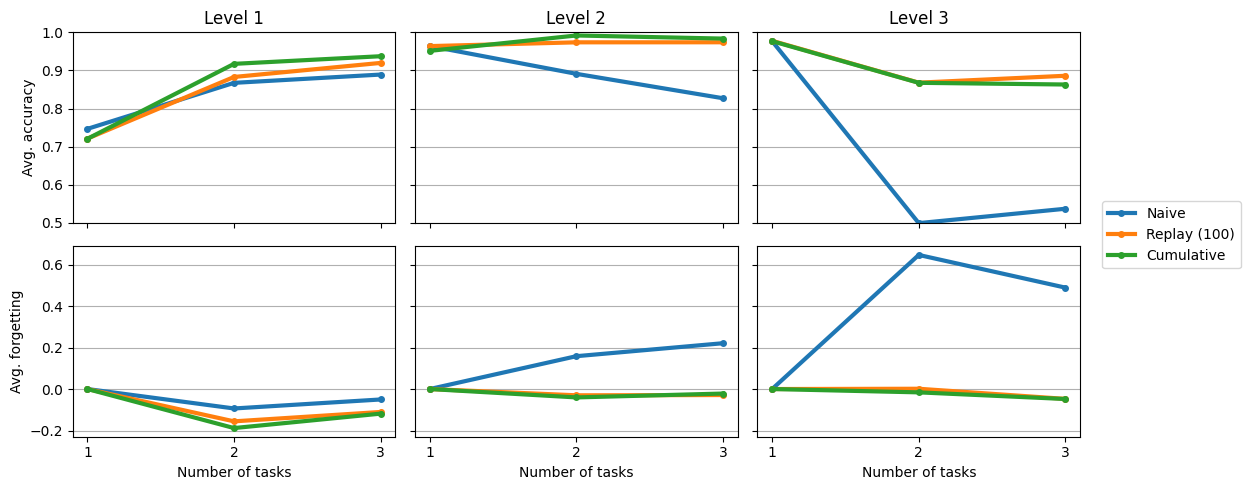

In [57]:
fig, axes = plt.subplots(2, 3, sharex='all', sharey='row', figsize=(11, 5))
for level in range(3):

    results = [json.load(open(f"LNRNet_level_{level+1}_{strategy}_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r')) for strategy in strategies]

    avg_accs = []
    avg_forgetting = []
    for result in results:
        avg_accs.append([metric['avg_accuracy'] for metric in result])
        avg_forgetting.append([metric['avg_forgetting'] for metric in result])
    
    mean_accs = np.mean(avg_accs, axis=1)
    mean_forgetting = np.mean(avg_forgetting, axis=1)

    avg_plot_args = []
    forgetting_plot_args = []
    x = ['1', '2', '3']
    for idx, strat in enumerate(strategies):
        avg_plot_args.append(x)
        avg_plot_args.append(mean_accs[idx])
        avg_plot_args.append('-o')

        forgetting_plot_args.append(x)
        forgetting_plot_args.append(mean_forgetting[idx])
        forgetting_plot_args.append('-o')

    axes[0][level].plot(*avg_plot_args, markersize=4, linewidth=3)
    axes[0][level].set_title(f"Level {level+1}")
    if level == 0:
        axes[0][level].set_ylabel("Avg. accuracy")
    axes[0][level].set_ylim(0.5, 1.)
    axes[0][level].grid(True, axis='y')

    axes[1][level].plot(*forgetting_plot_args, markersize=4, linewidth=3)
    if level == 0:
        axes[1][level].set_ylabel("Avg. forgetting")
    axes[1][level].set_xlabel("Number of tasks")
    axes[1][level].grid(True, axis='y')
    
fig.legend(['Naive', 'Replay (100)', 'Cumulative'], loc='center left', bbox_to_anchor=(1, 0.52))
plt.tight_layout()
plt.savefig(f'strategy_results_graph.png', dpi=300, bbox_inches='tight')

In [62]:
cumulative_results = json.load(open("LNRNet_level_3_Cumulative_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r'))
naive_results = json.load(open("LNRNet_level_3_Naive_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r'))
replay_results = json.load(open("LNRNet_level_3_Replay_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r'))

In [63]:
cumulative_avg_acc = np.array([metric['avg_accuracy'] for metric in cumulative_results])
naive_avg_acc = np.array([metric['avg_accuracy'] for metric in naive_results])
replay_avg_acc = np.array([metric['avg_accuracy'] for metric in replay_results])

In [64]:
mean_cum, std_cum = np.mean(cumulative_avg_acc, axis=0), np.std(cumulative_avg_acc, axis=0)
mean_naive, std_naive = np.mean(naive_avg_acc, axis=0), np.std(naive_avg_acc, axis=0)
mean_re, std_re = np.mean(replay_avg_acc, axis=0), np.std(replay_avg_acc, axis=0)

In [65]:
### 일단 바꿈
memory_sizes = ['25', '50', '75']

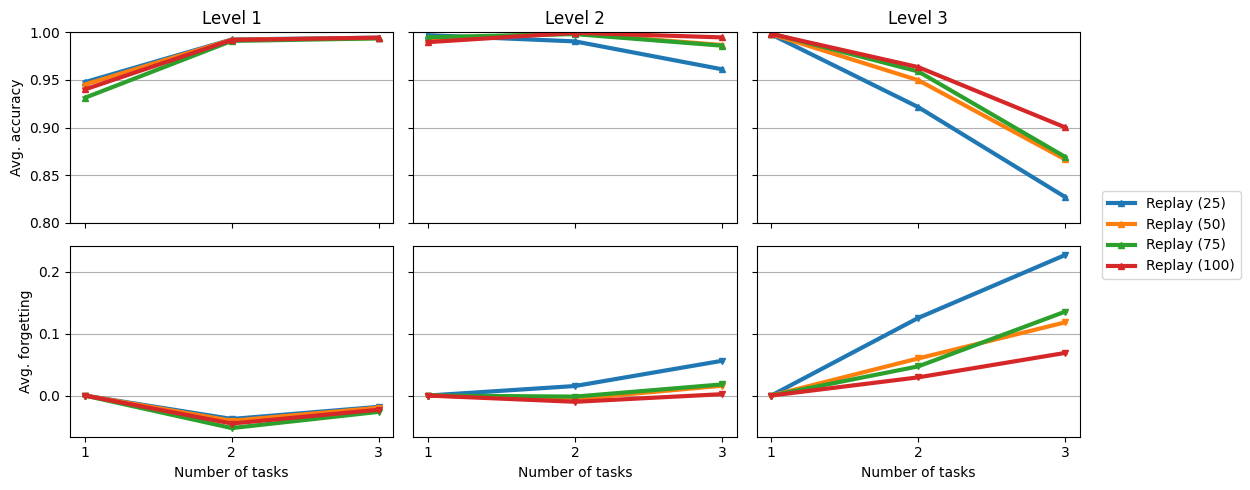

In [ ]:
fig, axes = plt.subplots(2, 3, sharex='all', sharey='row', figsize=(11, 5))
for level in range(3):

    results = [json.load(open(f"LNRNet_level_{level+1}_Replay_{memory}_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r')) for memory in memory_sizes]
    results.append(json.load(open(f"LNRNet_level_{level+1}_Replay_SGD_lr_0.01_momentum_0_l2_reg_0.01_results.json", 'r')))  # 메모리 100

    avg_accs = []
    avg_forgetting = []
    for result in results:
        avg_accs.append([metric['avg_accuracy'] for metric in result])
        avg_forgetting.append([metric['avg_forgetting'] for metric in result])
    
    mean_accs = np.mean(avg_accs, axis=1)
    mean_forgetting = np.mean(avg_forgetting, axis=1)

    avg_plot_args = []
    forgetting_plot_args = []
    x = ['1', '2', '3']
    for idx, mem_size in enumerate(['25', '50', '75', '100']):
        avg_plot_args.append(x)
        avg_plot_args.append(mean_accs[idx])
        avg_plot_args.append('-^')

        forgetting_plot_args.append(x)
        forgetting_plot_args.append(mean_forgetting[idx])
        forgetting_plot_args.append('-v')

    axes[0][level].plot(*avg_plot_args, markersize=4, linewidth=3)
    axes[0][level].set_title(f"Level {level+1}")
    if level == 0:
        axes[0][level].set_ylabel("Avg. accuracy")
    axes[0][level].set_ylim(0.8, 1.)
    axes[0][level].grid(True, axis='y')

    axes[1][level].plot(*forgetting_plot_args, markersize=4, linewidth=3)
    if level == 0:
        axes[1][level].set_ylabel("Avg. forgetting")
    axes[1][level].set_xlabel("Number of tasks")
    axes[1][level].grid(True, axis='y')
    
fig.legend([f'Replay ({size})' for size in [25, 50, 75, 100]], loc='center left', bbox_to_anchor=(1, 0.52))
plt.tight_layout()
plt.savefig(f'replay_results_graph.png', dpi=300, bbox_inches='tight')

In [ ]:
x = ['1', '2', '3']

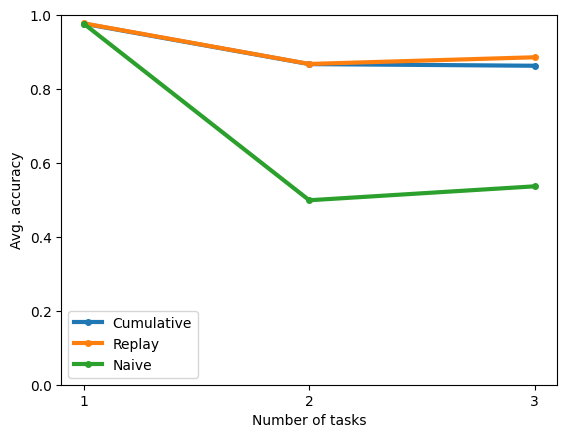

In [66]:
plt.plot(x, mean_cum, '-o', x, mean_re, '-o', x, mean_naive, '-o', markersize=4, linewidth=3)
plt.ylabel("Avg. accuracy")
plt.ylim(0., 1.)
plt.xlabel("Number of tasks")
plt.legend(["Cumulative", "Replay", "Naive"])

In [ ]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu

In [ ]:
mannwhitneyu(replay_avg_acc[:, 2], cumulative_avg_acc[:, 2])

MannwhitneyuResult(statistic=1393.5, pvalue=0.32418845118821493)

((array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759,
         -1.21163342, -1.113805  , -1.02561527, -0.94475674, -0.86964726,
         -0.79915021, -0.73241807, -0.66879925, -0.6077796 , -0.54894415,
         -0.49195112, -0.43651377, -0.38238727, -0.32935914, -0.27724191,
         -0.2258675 , -0.17508277, -0.12474591, -0.07472335, -0.02488719,
          0.02488719,  0.07472335,  0.12474591,  0.17508277,  0.2258675 ,
          0.27724191,  0.32935914,  0.38238727,  0.43651377,  0.49195112,
          0.54894415,  0.6077796 ,  0.66879925,  0.73241807,  0.79915021,
          0.86964726,  0.94475674,  1.02561527,  1.113805  ,  1.21163342,
          1.32267759,  1.45296849,  1.61402323,  1.83293478,  2.20385432]),
  array([0.98412698, 0.99206349, 0.99206349, 0.99603175, 0.99603175,
         0.99603175, 0.99603175, 0.99603175, 0.99603175, 0.99603175,
         0.99603175, 0.99603175, 0.99603175, 0.99603175, 0.99603175,
         0.99603175, 0.99603175, 0.99603175, 0.9960

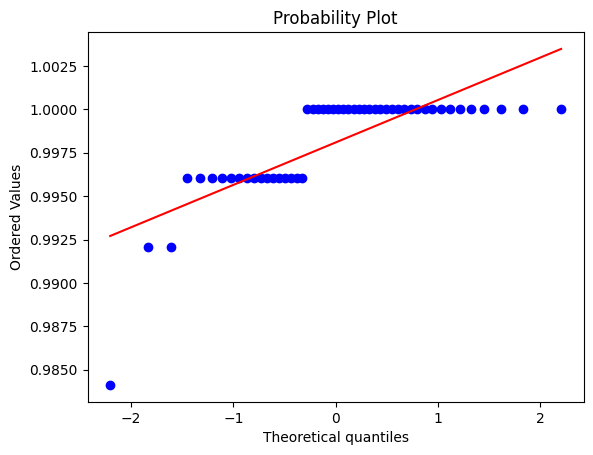

In [ ]:
fig, ax = plt.subplots()
probplot(cumulative_avg_acc[:, 0], plot=ax)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  5., 24., 19.]),
 array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
        0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
        0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
        0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
        0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
 <BarContainer object of 50 artists>)

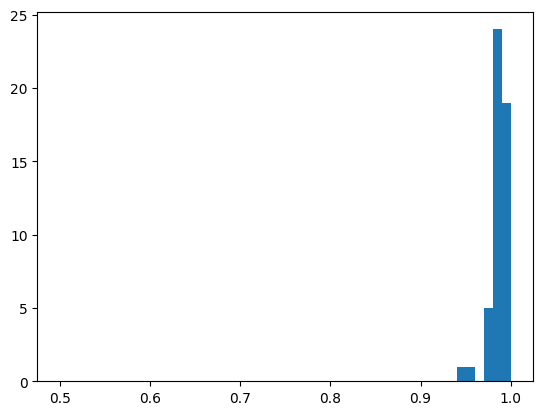

In [ ]:
plt.hist(cumulative_avg_acc[:, 1], bins=50, range=[0.5, 1])